In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

In [3]:
import warnings
warnings.filterwarnings('ignore') 

In [4]:
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None) 
pd.set_option('display.width', None) 
pd.set_option('display.max_info_columns', 500)
pd.set_option('display.max_info_rows', 500)
sns.set_style(style='darkgrid') 

In [5]:
df = pd.read_csv('train.csv')
row_count = df.shape[0]
null_cutoff = row_count * 0.50
null_cutoff

730.0

In [6]:
def display_nulls(df):
    df_nulls = pd.DataFrame(df.isna().sum(axis=0)).reset_index()
    df_nulls.columns = ['Field', 'Counts']
    df_nulls['percent'] = df_nulls.Counts/df.shape[0] * 100
    df_nulls = df_nulls[df_nulls.Counts!=0]
    df_nulls.sort_values(by='percent', ascending=False, inplace=True)
    return df_nulls

In [7]:
## This function will find the columns which have a high repeation of a same value.
def get_low_variance(df, cutoff):
    drop_list=[]
    for feature in df.columns:
        df_vc = pd.DataFrame(df[feature].value_counts()).reset_index()
        df_vc.columns=['Value', 'Count']
        df_vc['Percent'] = 100* df_vc.Count / df_vc.Count.sum()
        df_vc = df_vc[df_vc.Percent>cutoff]
        if df_vc.shape[0]>0:
            drop_list.append(feature)
    return drop_list


In [8]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Dropping the columns which have more than 50% as Nulls

In [9]:
df_nulls=display_nulls(df)
df_nulls=df_nulls[df_nulls.percent>50]
df_nulls

,Field,Counts,percent
72,PoolQC,1453,99.520548
74,MiscFeature,1406,96.301370
6,Alley,1369,93.767123
73,Fence,1179,80.753425


In [10]:
drop_calls = list(df_nulls.Field)
drop_calls

['PoolQC', 'MiscFeature', 'Alley', 'Fence']

In [11]:
df_trim = df.drop(columns = drop_calls)
df_trim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 77 columns):
Id               int64
MSSubClass       int64
MSZoning         object
LotFrontage      float64
LotArea          int64
Street           object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
OverallQual      int64
OverallCond      int64
YearBuilt        int64
YearRemodAdd     int64
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
MasVnrArea       float64
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinSF1       int64
BsmtFinType2     object
BsmtFinSF2       int64
BsmtUnfSF        int64
TotalBsmtSF  

#### As per the data dictionary, if the Fire Place Qu is not defined, it means that there is no fireplace.

In [12]:
df_trim.FireplaceQu.value_counts()

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

In [13]:
df_trim.FireplaceQu.fillna('NA', inplace=True)

In [14]:
display_nulls(df_trim)

,Field,Counts,percent
3,LotFrontage,259,17.739726
57,GarageType,81,5.547945
58,GarageYrBlt,81,5.547945
59,GarageFinish,81,5.547945
62,GarageQual,81,5.547945
63,GarageCond,81,5.547945
31,BsmtExposure,38,2.602740
34,BsmtFinType2,38,2.602740
29,BsmtQual,37,2.534247
30,BsmtCond,37,2.534247


#### Let us impute for LotFrontage
 We can keep the NA as the median over here

In [15]:
df_trim.LotFrontage.fillna(df_trim.LotFrontage.median(), inplace=True)

#### Now, we can drop the rows which have these columns as null

In [16]:
df_nona = df_trim[df_trim.isna().sum(axis=1)==0]
df_nona.shape

(1338, 77)

In [17]:
col_low_variance=get_low_variance(df_nona, 85)
col_low_variance

['Street',
 'LandContour',
 'Utilities',
 'LandSlope',
 'Condition1',
 'Condition2',
 'BldgType',
 'RoofMatl',
 'ExterCond',
 'BsmtCond',
 'BsmtFinType2',
 'BsmtFinSF2',
 'Heating',
 'CentralAir',
 'Electrical',
 'LowQualFinSF',
 'BsmtHalfBath',
 'KitchenAbvGr',
 'Functional',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'SaleType']

In [18]:
df_nona.drop(columns=col_low_variance, inplace=True)

In [60]:
df_nona.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LotConfig', 'Neighborhood', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'MoSold',
       'YrSold', 'SaleCondition', 'SalePrice', 'Age', 'RemodAge'],
      dtype='object')

In [19]:
df_nona.shape

(1338, 49)

In [20]:
df_nona.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,YrSold,SalePrice
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.00000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,731.228700,56.136024,70.438714,10706.294469,6.219731,5.596413,1973.029148,1985.668909,110.360239,464.234679,582.494768,1095.947683,1176.221973,357.141256,1537.585202,0.438714,1.575486,0.402840,2.864723,6.550075,0.648729,1978.596413,1.87145,501.449925,99.384903,47.782511,6.331839,2007.805680,186761.782511
std,421.779691,41.252576,22.170305,10336.621126,1.324472,1.078124,29.563540,20.296463,185.604816,458.792420,439.950528,405.554435,386.644986,440.324982,520.579960,0.515630,0.547570,0.504185,0.776677,1.585071,0.645393,24.773741,0.63428,186.761863,127.537065,65.362562,2.699437,1.330691,78913.847668
min,1.000000,20.000000,21.000000,1300.000000,2.000000,2.000000,1880.000000,1950.000000,0.000000,0.000000,0.000000,105.000000,438.000000,0.000000,438.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,1900.000000,1.00000,160.000000,0.000000,0.000000,1.000000,2006.000000,35311.000000
25%,366.250000,20.000000,60.000000,7744.000000,5.000000,5.000000,1956.000000,1968.000000,0.000000,0.000000,248.000000,819.750000,894.000000,0.000000,1160.000000,0.000000,1.000000,0.000000,2.000000,5.000000,0.000000,1962.000000,1.00000,377.500000,0.000000,0.000000,5.000000,2007.000000,135000.000000
50%,730.500000,50.000000,69.000000,9600.000000,6.000000,5.000000,1976.000000,1994.500000,0.000000,413.000000,489.000000,1021.500000,1098.000000,0.000000,1480.000000,0.000000,2.000000,0.000000,3.000000,6.000000,1.000000,1980.000000,2.00000,484.000000,6.000000,28.000000,6.000000,2008.000000,168500.000000
75%,1098.750000,70.000000,80.000000,11760.750000,7.000000,6.000000,2001.000000,2004.000000,174.000000,733.000000,815.750000,1324.000000,1414.000000,740.500000,1791.500000,1.000000,2.000000,1.000000,3.000000,7.000000,1.000000,2002.000000,2.00000,583.000000,174.500000,70.000000,8.000000,2009.000000,220000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,2336.000000,6110.000000,4692.000000,2065.000000,5642.000000,2.000000,3.000000,2.000000,6.000000,12.000000,3.000000,2010.000000,4.00000,1418.000000,857.000000,547.000000,12.000000,2010.000000,755000.000000


In [21]:
df_nona.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,YrSold,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Reg,Inside,CollgCr,2Story,7,5,2003,2003,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,PConc,Gd,No,GLQ,706,150,856,Ex,856,854,1710,1,2,1,3,Gd,8,0,NA,Attchd,2003.0,RFn,2,548,0,61,2,2008,Normal,208500
1,2,20,RL,80.0,9600,Reg,FR2,Veenker,1Story,6,8,1976,1976,Gable,MetalSd,MetalSd,None,0.0,TA,CBlock,Gd,Gd,ALQ,978,284,1262,Ex,1262,0,1262,0,2,0,3,TA,6,1,TA,Attchd,1976.0,RFn,2,460,298,0,5,2007,Normal,181500
2,3,60,RL,68.0,11250,IR1,Inside,CollgCr,2Story,7,5,2001,2002,Gable,VinylSd,VinylSd,BrkFace,162.0,Gd,PConc,Gd,Mn,GLQ,486,434,920,Ex,920,866,1786,1,2,1,3,Gd,6,1,TA,Attchd,2001.0,RFn,2,608,0,42,9,2008,Normal,223500
3,4,70,RL,60.0,9550,IR1,Corner,Crawfor,2Story,7,5,1915,1970,Gable,Wd Sdng,Wd Shng,None,0.0,TA,BrkTil,TA,No,ALQ,216,540,756,Gd,961,756,1717,1,1,0,3,Gd,7,1,Gd,Detchd,1998.0,Unf,3,642,0,35,2,2006,Abnorml,140000
4,5,60,RL,84.0,14260,IR1,FR2,NoRidge,2Story,8,5,2000,2000,Gable,VinylSd,VinylSd,BrkFace,350.0,Gd,PConc,Gd,Av,GLQ,655,490,1145,Ex,1145,1053,2198,1,2,1,4,Gd,9,1,TA,Attchd,2000.0,RFn,3,836,192,84,12,2008,Normal,250000


#### As per the Data Dictionary, few numeric looking features are actually categorical ones. They are
- MSSubClass
- OverallQual
- OverallCond
- MoSold
- YrSold

#### Also, the columns - YearBuilt and YearRemodAdd can be converted to Age and RemodAge which will make better numeric columns

In [22]:
cols_categ = [
    'MSSubClass',
    'OverallQual',
    'OverallCond',
    'MoSold',
    'YrSold'
]
df_nona[cols_categ].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338 entries, 0 to 1459
Data columns (total 5 columns):
MSSubClass     int64
OverallQual    int64
OverallCond    int64
MoSold         int64
YrSold         int64
dtypes: int64(5)
memory usage: 62.7 KB


#### Converting them to the Strings

In [23]:
df_nona[cols_categ] = df_nona[cols_categ].astype(str)
df_nona[cols_categ].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338 entries, 0 to 1459
Data columns (total 5 columns):
MSSubClass     object
OverallQual    object
OverallCond    object
MoSold         object
YrSold         object
dtypes: object(5)
memory usage: 62.7+ KB


#### Adding ages

In [24]:
from datetime import datetime as dt
current_year = dt.today().year
df_nona['Age'] = current_year - df_nona['YearBuilt']
df_nona['RemodAge'] = current_year - df_nona['YearRemodAdd']
df_nona.drop(columns=['YearBuilt', 'YearRemodAdd'], inplace=True)
df_nona.describe()

,Id,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice,Age,RemodAge
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.00000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,731.228700,70.438714,10706.294469,110.360239,464.234679,582.494768,1095.947683,1176.221973,357.141256,1537.585202,0.438714,1.575486,0.402840,2.864723,6.550075,0.648729,1978.596413,1.87145,501.449925,99.384903,47.782511,186761.782511,46.970852,34.331091
std,421.779691,22.170305,10336.621126,185.604816,458.792420,439.950528,405.554435,386.644986,440.324982,520.579960,0.515630,0.547570,0.504185,0.776677,1.585071,0.645393,24.773741,0.63428,186.761863,127.537065,65.362562,78913.847668,29.563540,20.296463
min,1.000000,21.000000,1300.000000,0.000000,0.000000,0.000000,105.000000,438.000000,0.000000,438.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,1900.000000,1.00000,160.000000,0.000000,0.000000,35311.000000,10.000000,10.000000
25%,366.250000,60.000000,7744.000000,0.000000,0.000000,248.000000,819.750000,894.000000,0.000000,1160.000000,0.000000,1.000000,0.000000,2.000000,5.000000,0.000000,1962.000000,1.00000,377.500000,0.000000,0.000000,135000.000000,19.000000,16.000000
50%,730.500000,69.000000,9600.000000,0.000000,413.000000,489.000000,1021.500000,1098.000000,0.000000,1480.000000,0.000000,2.000000,0.000000,3.000000,6.000000,1.000000,1980.000000,2.00000,484.000000,6.000000,28.000000,168500.000000,44.000000,25.500000
75%,1098.750000,80.000000,11760.750000,174.000000,733.000000,815.750000,1324.000000,1414.000000,740.500000,1791.500000,1.000000,2.000000,1.000000,3.000000,7.000000,1.000000,2002.000000,2.00000,583.000000,174.500000,70.000000,220000.000000,64.000000,52.000000
max,1460.000000,313.000000,215245.000000,1600.000000,5644.000000,2336.000000,6110.000000,4692.000000,2065.000000,5642.000000,2.000000,3.000000,2.000000,6.000000,12.000000,3.000000,2010.000000,4.00000,1418.000000,857.000000,547.000000,755000.000000,140.000000,70.000000


In [25]:
df_obj = df_nona.select_dtypes(object)
col = list(df_obj.columns)[1:]
df_obj.shape

(1338, 25)

<Figure size 1800x5040 with 0 Axes>

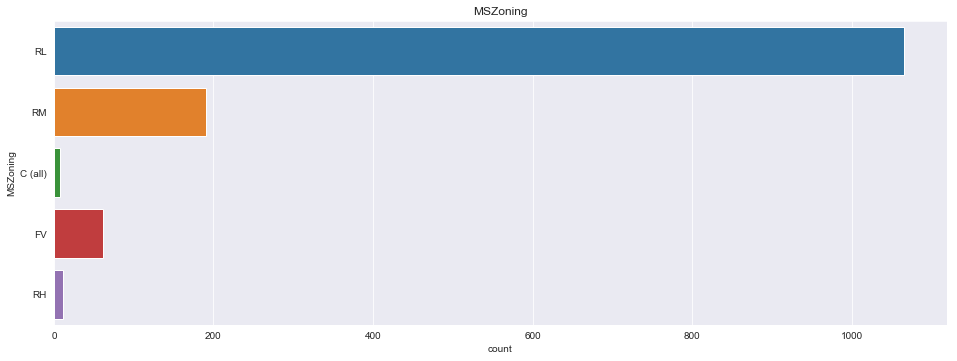

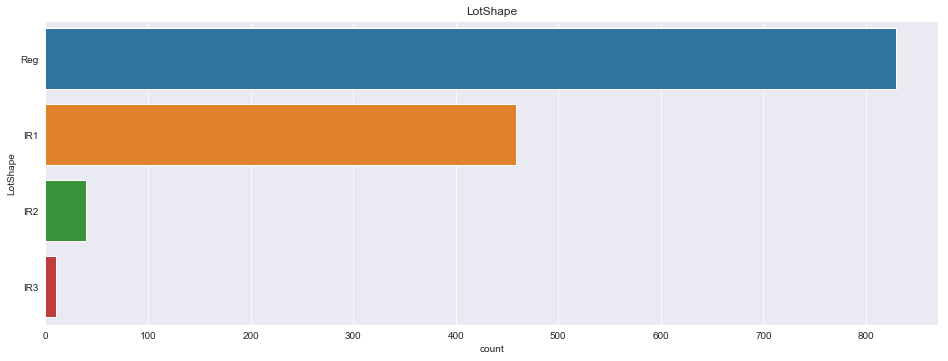

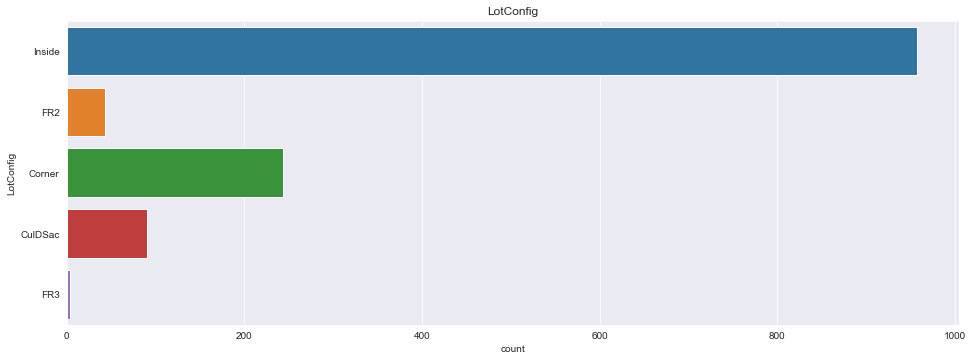

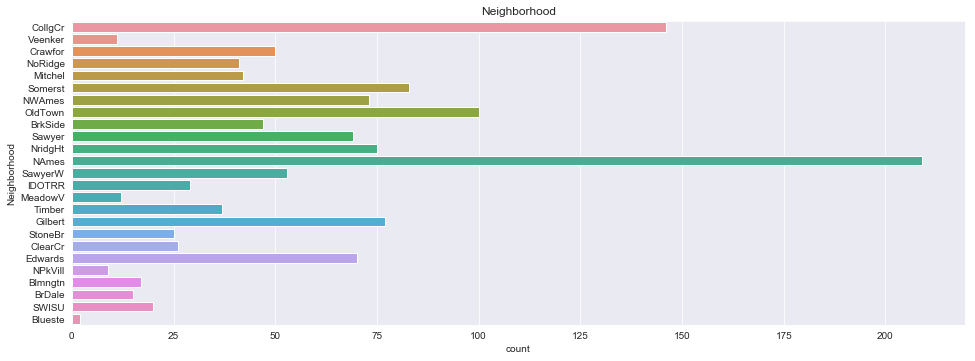

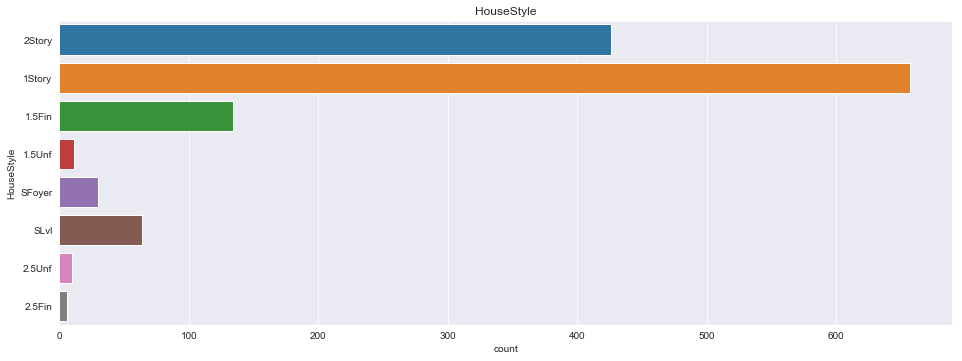

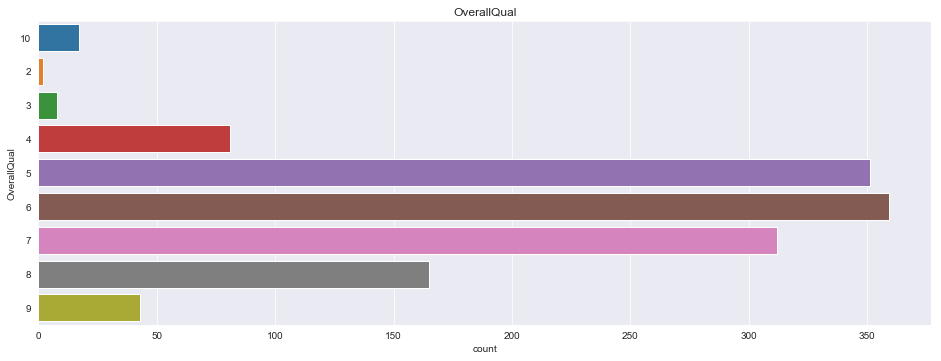

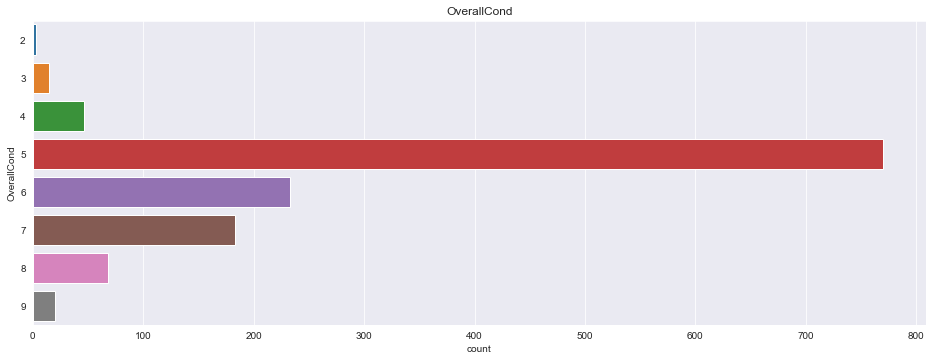

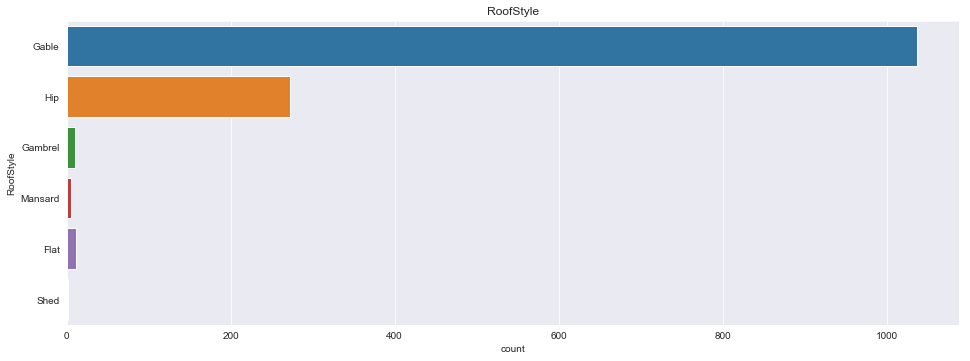

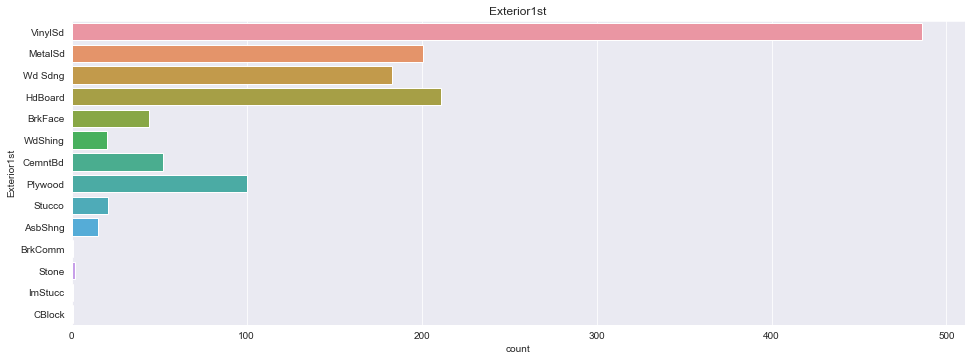

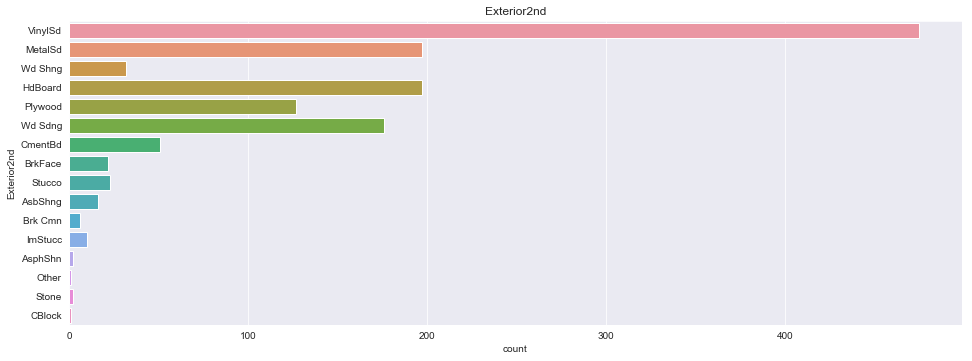

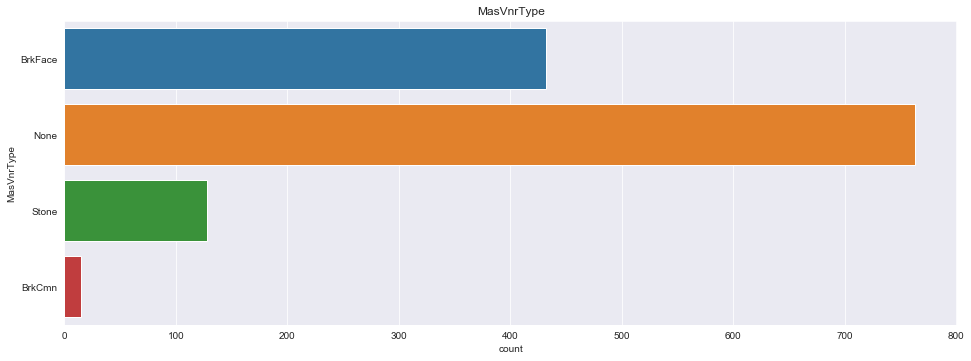

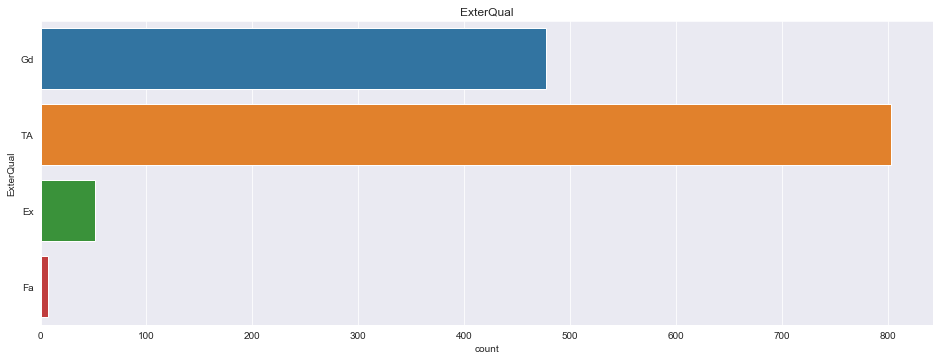

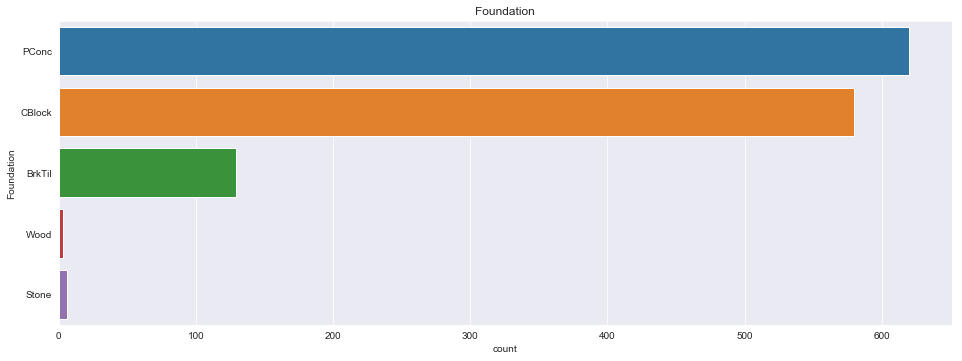

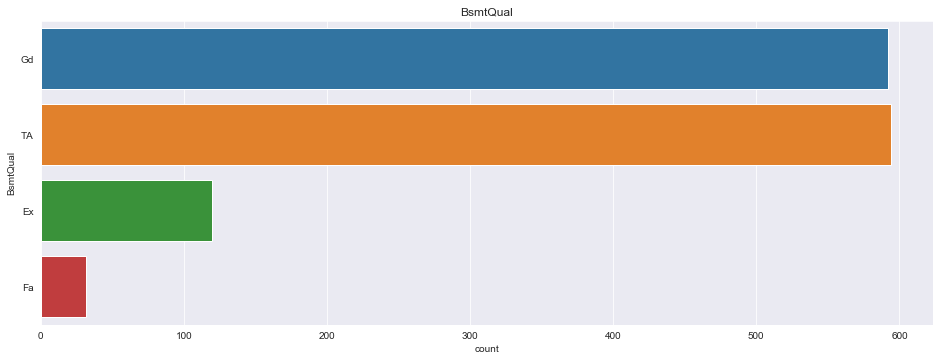

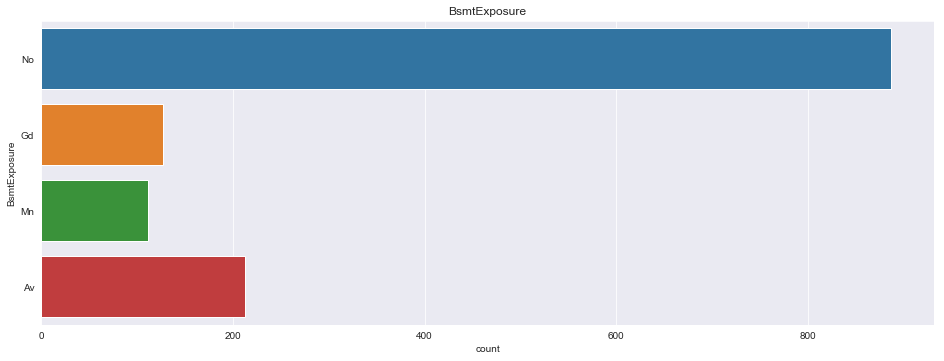

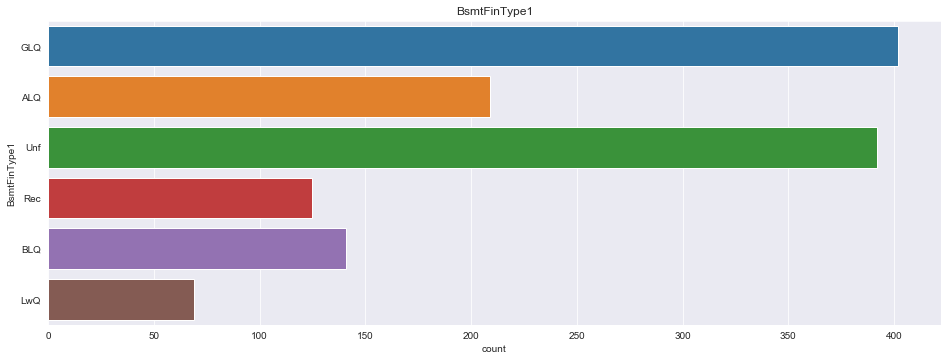

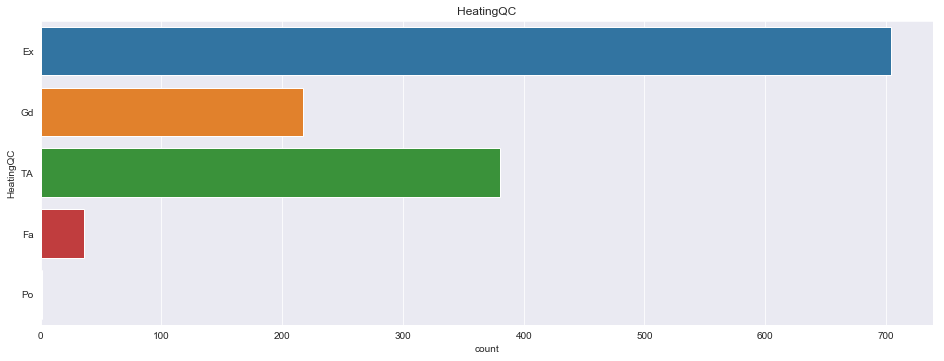

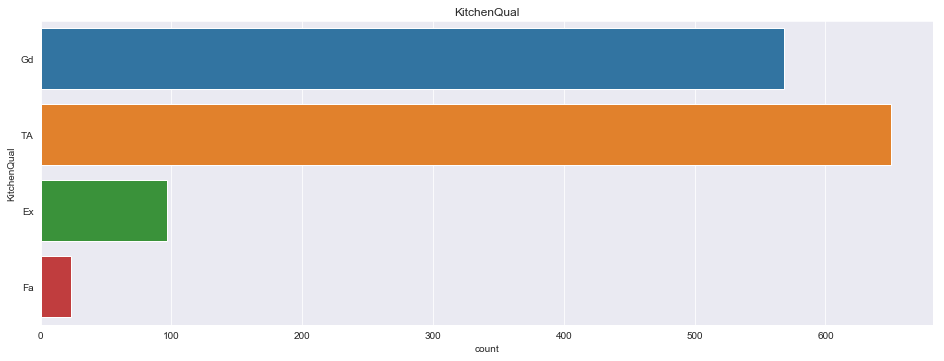

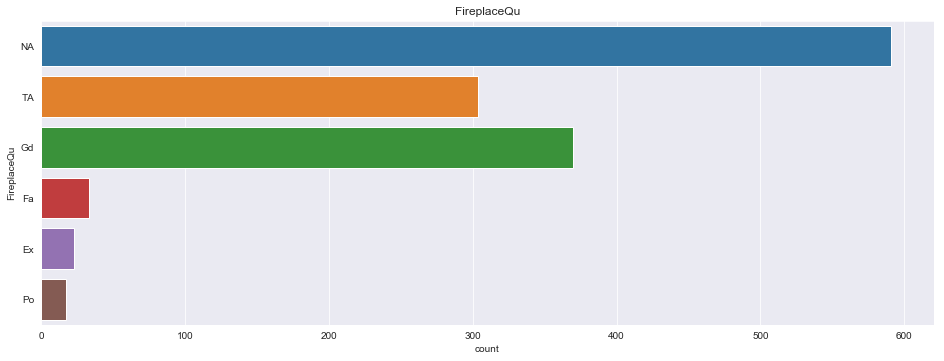

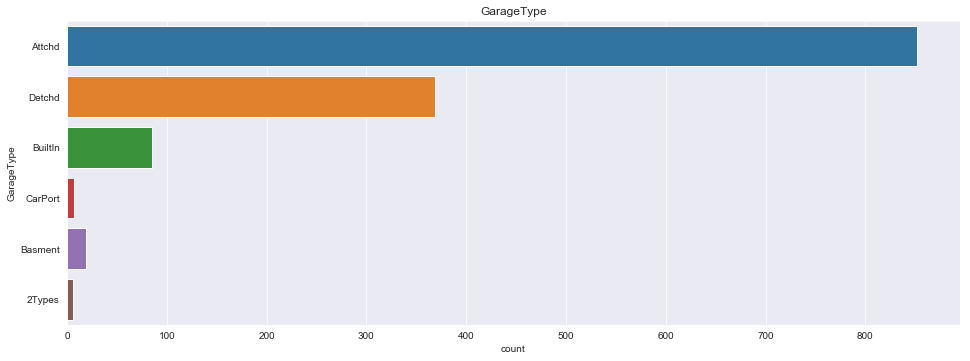

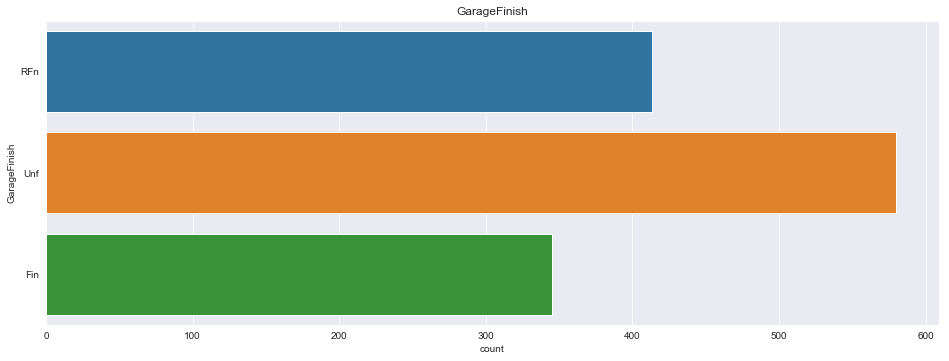

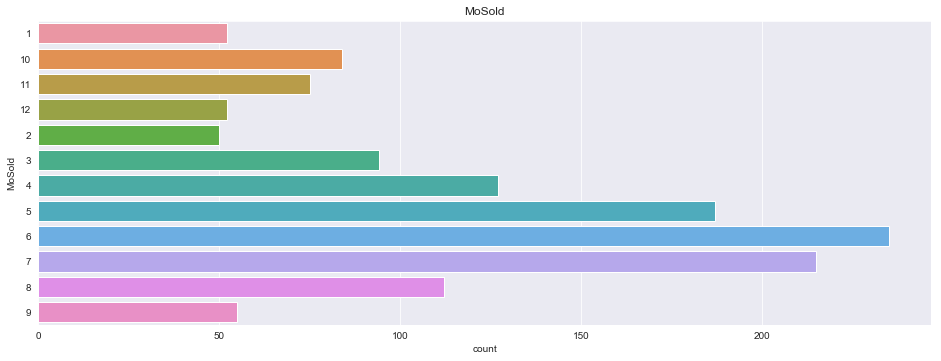

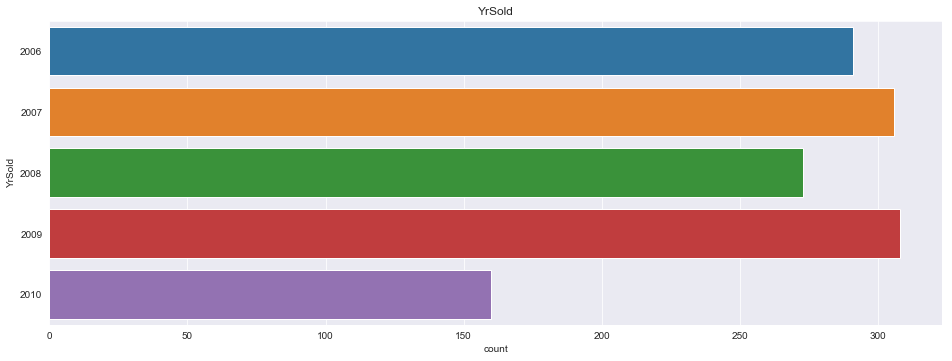

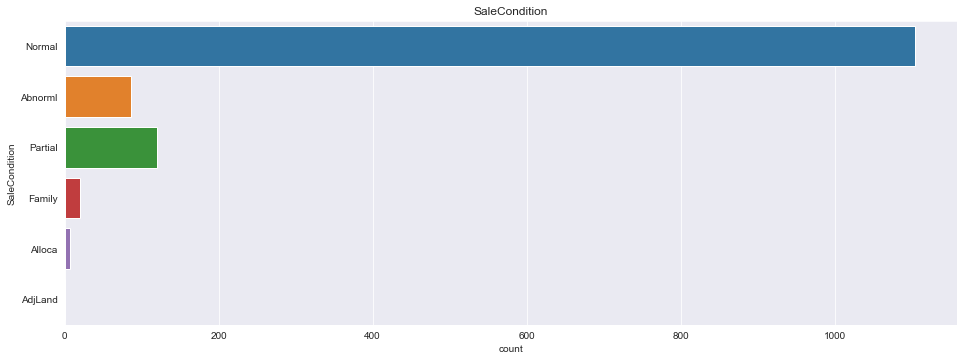

In [26]:
plt.figure(figsize=[25,70]) 
for i in enumerate(col):
    plt.figure(figsize=[16,160]) 
    plt.subplot(len(col),1, i[0]+1)
    sns.countplot(y = i[1], data=df_obj) 
    plt.title(i[1])
    plt.show() 

In [27]:
df_num = df_nona.select_dtypes(np.number)
col = list(df_num.columns)[1:]
df_num.shape

(1338, 24)

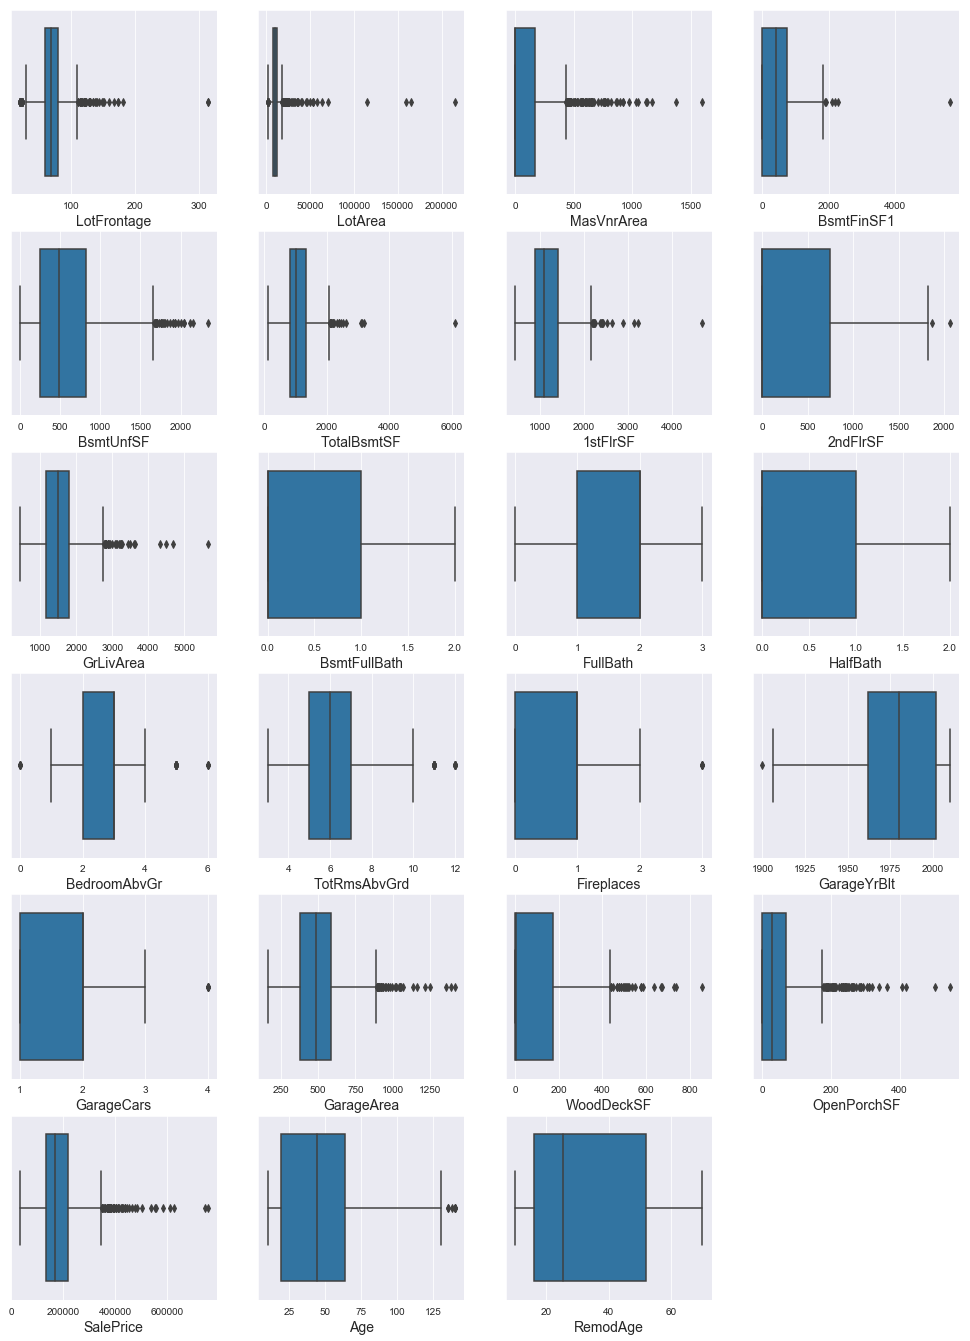

In [28]:
plt.figure(figsize = (17,40))
for i, feature in enumerate(col):
    plt.subplot(10,4, i+1)
    sns.boxplot(x = feature, data = df_num)
    plt.xlabel(feature, fontsize=14)
plt.show()

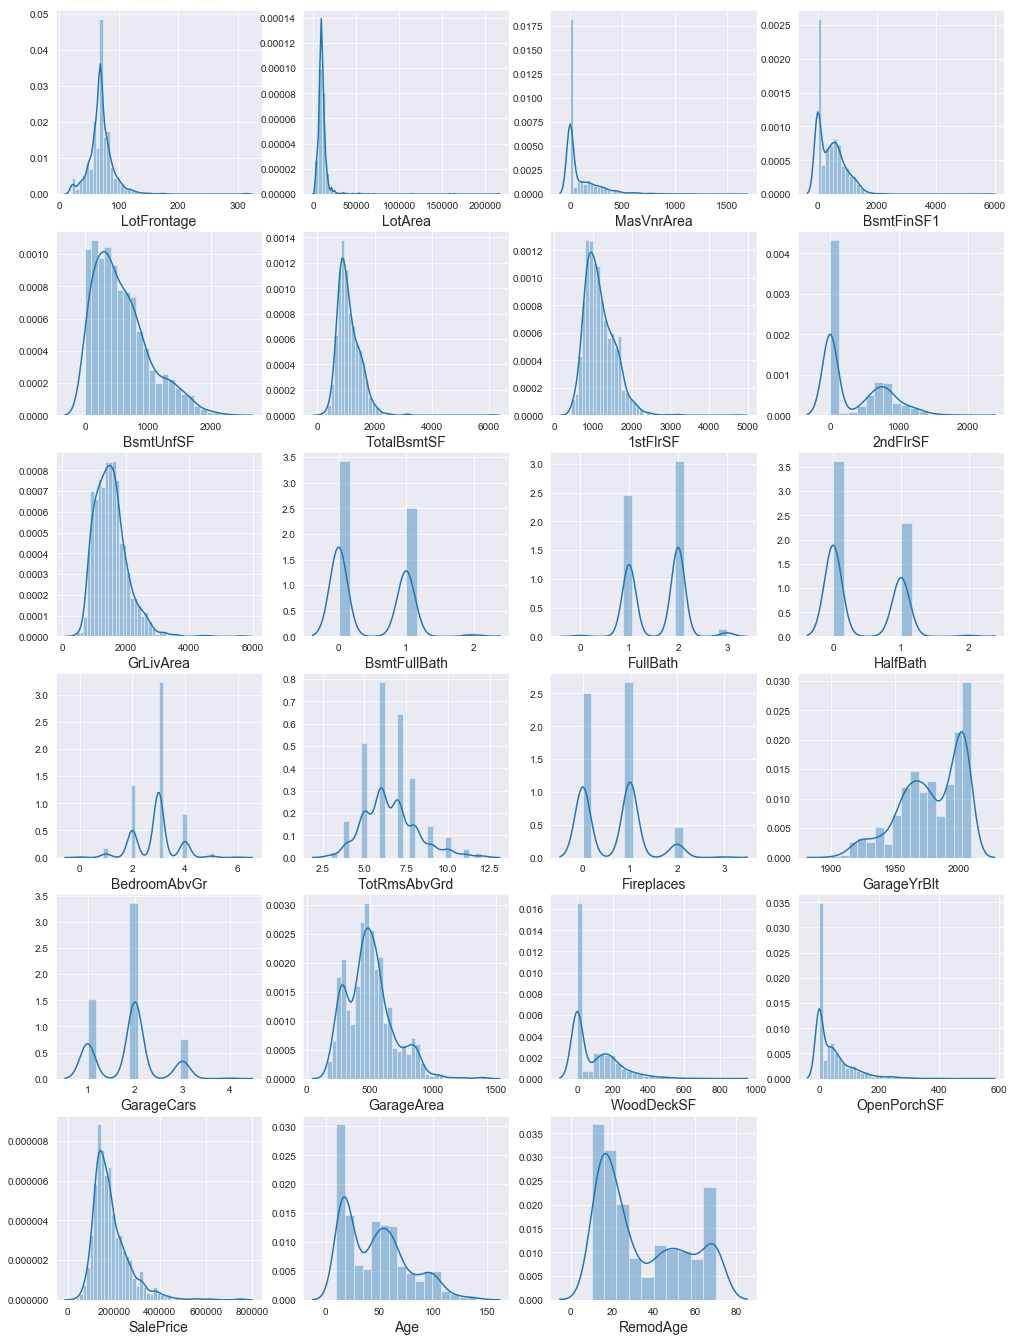

In [29]:
plt.figure(figsize = (17,40))
for i, feature in enumerate(col):
    plt.subplot(10,4, i+1)
    sns.distplot(df_num[feature])
    plt.xlabel(feature, fontsize=14)
plt.show()

#### Converting the categorical columns to dummies

In [30]:
df_dummies = pd.get_dummies(df_obj)
df_dummies.head()

,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,OverallQual_10,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsbShng,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NA,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,

In [31]:
df_train = pd.concat([df_dummies, df_num], axis=1)
df_train.shape

(1338, 213)

Checking the spread of the Sale Price again

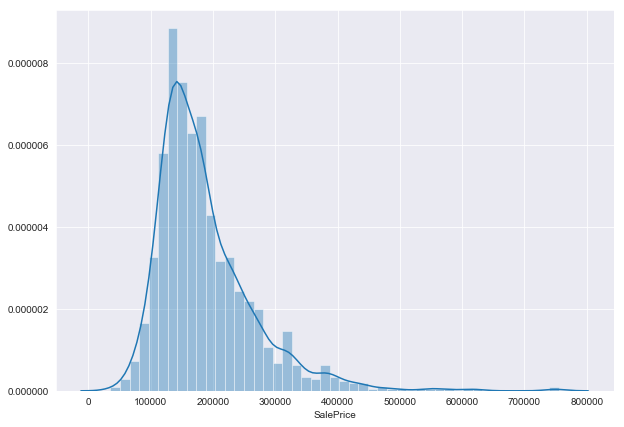

In [32]:
plt.figure(figsize=[10, 7])
sns.distplot(df_num['SalePrice'])
plt.show()

As the SalePrice is not normally distributed, we will try with log (SalePrice)

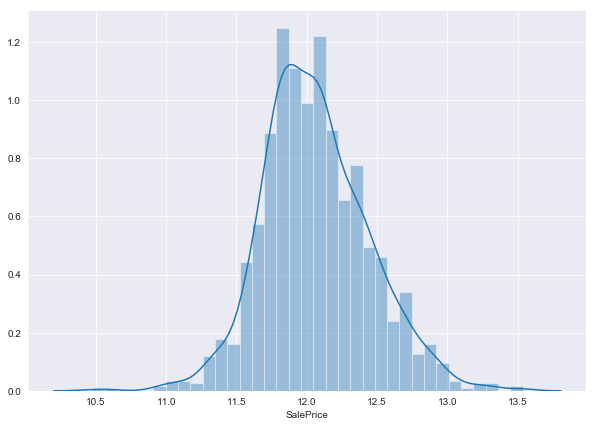

In [33]:
plt.figure(figsize=[10, 7])
sns.distplot(np.log(df_num['SalePrice']))
plt.show()

This is better. We will have the y as log(SalePrice)

In [116]:
y = df_train['SalePrice'].apply(np.log) # As decided earlier
X = df_train.loc[:, df_train.columns != 'SalePrice']
X.shape

(1338, 212)

In [117]:
# scaling the features
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

cols = X.columns
X = pd.DataFrame(scaler.fit_transform(X))
X.columns = cols
X.head()

,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,OverallQual_10,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsbShng,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NA,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Id,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,Age,RemodAge
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0

In [106]:
X.shape

(1338, 212)

#### We will need this function pretty often

In [36]:
def print_r2scores(result, alpha):
    (r2_train, r2_test) = tuple(result.loc[result.params=={'alpha':alpha}, \
                                            ['mean_train_score', 'mean_test_score']].values[0])
    print ('The train R-Square is %.2f%% and the test R-square is %.2f%%' % (r2_train*100, 100*r2_test))

## Ridge Regression

In [68]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 7.5, 8.0, 9.0, 10.0, 15, 20, 30]}

ridge = Ridge()

# cross validation
folds = 5
model_ridge = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 0)            
model_ridge.fit(X, y) 
cv_results = pd.DataFrame(model_ridge.cv_results_)

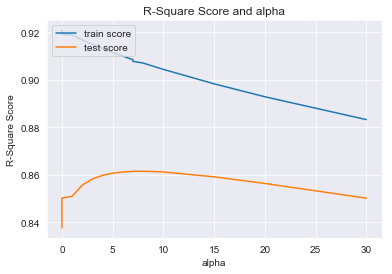

In [69]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('R-Square Score')
plt.title("R-Square Score and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

A good value of the alpha seems to be between 5 and 10. **I will take the optimal value of alpha/lambda as 7.5**

In [70]:
alpha = 7.5
ridge_best = Ridge(alpha=alpha)
ridge_best.fit(X, y)
print_r2scores(cv_results, alpha=7.5)

The train R-Square is 90.77% and the test R-square is 86.14%


In [40]:
dict_features = {'feature':list(X.columns), 'coefs' : list(np.abs(ridge.coef_))}
df_features = pd.DataFrame.from_dict(dict_features).sort_values(by='coefs', ascending=False)
df_features.head(5)

,feature,coefs
198,GrLivArea,0.192518
15,MSZoning_C (all),0.182948
196,1stFlrSF,0.162704
203,TotRmsAbvGrd,0.148858
70,OverallQual_9,0.146616


### Inference: As per Ridge, the top 5 features which affect (positively or negatively) the Sale Price are:
- **GrLivArea**: Above grade (ground) living area square feet
- **MS Zoning** to be C (Commercial)
- **1stFlrSF**: First Floor square feet
- **TotRmsAbvGrd**: Total rooms above grade (does not include bathrooms)
- **OverallQual** to be 9

If we double the value of the alpha (lambda)

In [41]:
alpha = alpha*2
ridge = Ridge(alpha=alpha)
ridge.fit(X, y)
print_r2scores(cv_results, alpha=alpha)

The train R-Square is 89.83% and the test R-square is 85.91%


In [42]:
dict_features = {'feature':list(X.columns), 'coefs' : list(np.abs(ridge.coef_))}
df_features = pd.DataFrame.from_dict(dict_features).sort_values(by='coefs', ascending=False)
df_features.head(5)

,feature,coefs
198,GrLivArea,0.150369
203,TotRmsAbvGrd,0.146294
206,GarageCars,0.132139
15,MSZoning_C (all),0.129579
200,FullBath,0.129369


### Inference: As per Ridge with double the ideal alpha value, the top 5 features which affect (positively or negatively) the Sale Price are:
- **GrLivArea**: Above grade (ground) living area square feet
- **TotRmsAbvGrd**: Total rooms above grade (does not include bathrooms)
- **GarageCars**: Size of garage in car capacity
- **MS Zoning** to be C (Commercial)
- **FullBath**: Full bathrooms above grade

#### Hence, there is good amount of change in the model if we double the value of alpha in Ridge

---
## Lasso

In [43]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.0002] + list ( np.array(list(range(6, 100, 5)))/10000 ) }

lasso = Lasso()

# cross validation
model_lasso = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 0)            

model_lasso.fit(X, y) 
cv_results = pd.DataFrame(model_lasso.cv_results_)

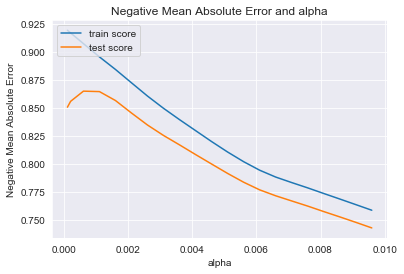

In [44]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [45]:
alpha =0.0001
print_r2scores(cv_results, 0.0001)

The train R-Square is 91.91% and the test R-square is 85.05%


In [46]:
lasso = Lasso(alpha=alpha)
lasso.fit(X, y) 
dict_features = {'feature':list(X.columns), 'coefs' : list(np.round(np.abs(lasso.coef_), 2))}
df_features = pd.DataFrame.from_dict(dict_features).sort_values(by='coefs', ascending=False)
df_features.head(5)

,feature,coefs
198,GrLivArea,0.94
15,MSZoning_C (all),0.38
63,OverallQual_2,0.35
191,LotArea,0.28
86,Exterior1st_BrkComm,0.25


### Inference: As per Lasso, the top 5 features which affect (positively or negatively) the Sale Price are:
- **GrLivArea**: Above grade (ground) living area square feet
- **MS Zoning** to be C (Commercial)
- **OverallQual** to be 2
- **LotArea**: Lot size in square feet
- **Exterior1st_BrkComm**: Exterior covering on house as Common Bricks

In [47]:
#Let's check with the double of the alpha value
print_r2scores(cv_results, 0.0002)

The train R-Square is 91.67% and the test R-square is 85.58%


In [48]:
lasso = Lasso(alpha=alpha*2)
lasso.fit(X, y) 
dict_features = {'feature':list(X.columns), 'coefs' : list(np.round(np.abs(lasso.coef_), 2))}
df_features = pd.DataFrame.from_dict(dict_features).sort_values(by='coefs', ascending=False)
df_features.head(5)

,feature,coefs
198,GrLivArea,0.93
15,MSZoning_C (all),0.37
63,OverallQual_2,0.29
191,LotArea,0.21
70,OverallQual_9,0.20


##### Not much difference in case of Lasso in the R-Square scores. However the 5th most important feature is not Overall Quality to be 9

In [49]:
df_features.shape

(212, 2)

In [50]:
df_features = df_features[df_features.coefs != 0]
df_features.shape

(120, 2)

After removing the features with 0 coefficients, the remaining features in the model are only 137. This is important. The Lasso is automatically picking the best features.
#### Now, let's drop the top 5 prominent features from the Lasso

In [51]:
X_drop = X.drop(columns=list(df_features.head(5)['feature']))

In [52]:
model_lasso.fit(X_drop, y) 
cv_results = pd.DataFrame(model_lasso.cv_results_)

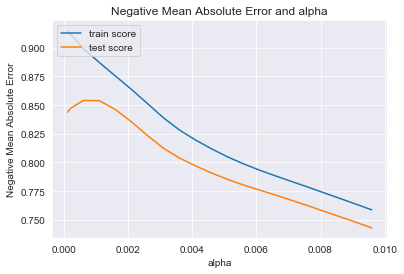

In [53]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [54]:
alpha =0.0001
print_r2scores(cv_results, 0.0001)

The train R-Square is 91.53% and the test R-square is 84.38%


In [55]:
lasso_drop = Lasso(alpha=alpha)
lasso_drop.fit(X_drop, y) 
dict_features = {'feature':list(X_drop.columns), 'coefs' : list(np.round(np.abs(lasso_drop.coef_), 2))}
df_features = pd.DataFrame.from_dict(dict_features).sort_values(by='coefs', ascending=False)
df_features.head(5)

,feature,coefs
192,1stFlrSF,0.80
15,MSZoning_FV,0.45
17,MSZoning_RL,0.40
193,2ndFlrSF,0.38
16,MSZoning_RH,0.37


### Inference: As per Lasso applied on data set without top 5 features,  the top 5 features which affect (positively or negatively) the Sale Price are:
- **1stFlrSF**: Above grade (ground) living area square feet
- **MS Zoning** to be FV (Commercial)
- **2ndFlrSF** Second floor square feet
- **MS Zoning**: to be RL (Residential Low Density)
- **MS Zoning**: to be RH (Residential High Density)

---
### Picking the ideal model: Lasso with alpha - 0.0001

In [56]:
alpha

0.0001

In [57]:
lasso = Lasso(alpha=alpha)
lasso.fit(X, y) 
dict_features = {'feature':list(X.columns), 'coefs' : list(np.round(np.abs(lasso.coef_), 2))}
df_features = pd.DataFrame.from_dict(dict_features).sort_values(by='coefs', ascending=False)
df_features.head(5)

,feature,coefs
198,GrLivArea,0.94
15,MSZoning_C (all),0.38
63,OverallQual_2,0.35
191,LotArea,0.28
86,Exterior1st_BrkComm,0.25


#### The above lasso model will be used

### Inference (posting again as discussed above): As per Lasso, the top 5 features which affect (positively or negatively) the Sale Price are:
- **GrLivArea**: Above grade (ground) living area square feet
- **MS Zoning** to be C (Commercial)
- **OverallQual** to be 2
- **LotArea**: Lot size in square feet
- **Exterior1st_BrkComm**: Exterior covering on house as Common Bricks

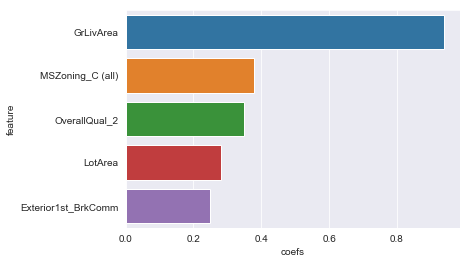

In [58]:
sns.barplot(x='coefs', y='feature', data=df_features.head())

#### The above graph shows the impact of the given features on the model

---
# Running on Test Data

In [86]:
df_test = pd.read_csv('test.csv')
cols = ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LotConfig', 'Neighborhood', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'MoSold',
       'YrSold', 'SaleCondition', 'YearBuilt', 'YearRemodAdd']

print (df_test.shape)
df_test = df_test[cols]

from datetime import datetime as dt
current_year = dt.today().year
df_test['Age'] = current_year - df_test['YearBuilt']
df_test['RemodAge'] = current_year - df_test['YearRemodAdd']
df_test.drop(columns=['YearBuilt', 'YearRemodAdd'], inplace=True)

df_test[cols_categ] = df_test[cols_categ].astype(str)
df_test = pd.concat([pd.get_dummies(df_test.select_dtypes(object)), df_test.select_dtypes(np.number)], axis=1)
print (df_test.shape)

(1459, 80)
(1459, 212)


In [140]:
display_nulls(df_test)

,Field,Counts,percent
190,LotFrontage,227,15.558602
205,GarageYrBlt,78,5.346127
192,MasVnrArea,15,1.028101
199,BsmtFullBath,2,0.137080
193,BsmtFinSF1,1,0.068540
194,BsmtUnfSF,1,0.068540
195,TotalBsmtSF,1,0.068540
206,GarageCars,1,0.068540
207,GarageArea,1,0.068540


In [141]:
df_test.LotFrontage.fillna(df_test.LotFrontage.median(), inplace=True)

In [142]:
df_test.GarageYrBlt.fillna(df_test.GarageYrBlt.median(), inplace=True)
df_test.MasVnrArea.fillna(df_test.MasVnrArea.median(), inplace=True)

df_test.BsmtFullBath.fillna(0, inplace=True)
df_test.BsmtFinSF1.fillna(0, inplace=True)
df_test.BsmtUnfSF.fillna(0, inplace=True)
df_test.TotalBsmtSF.fillna(0, inplace=True)
df_test.GarageCars.fillna(0, inplace=True)
df_test.GarageArea.fillna(0, inplace=True)

In [143]:
display_nulls(df_test)

,Field,Counts,percent


In [144]:
X_test = df_test.copy()
print (X_test.shape)
X_test.head()

(1459, 212)


,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,OverallQual_1,OverallQual_10,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallCond_1,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Id,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,Age,RemodAge
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1461,80.0,11622,0.0,468.0,270.0,882.0,896,0,896,0.0,1,0,2,5,0,1961.0,1.0,730.0,140,0,59,59
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,

In [145]:
cols = X_test.columns
X_test = pd.DataFrame(scaler.transform(X_test))
X_test.columns = cols
print (X_test.shape)

(1459, 212)


In [127]:
X_test.head()

,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,OverallQual_1,OverallQual_10,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallCond_1,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Id,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,Age,RemodAge
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0

In [148]:
y_test = np.exp(ridge_best.predict(X_test))

In [153]:
df_out = df_test[['Id']]
df_out['SalePrice'] = y_test
df_out.head()

,Id,SalePrice
0,1461,137916.800280
1,1462,174475.265268
2,1463,187660.416611
3,1464,184627.655666
4,1465,190346.456023


In [154]:
df_out.to_csv('prediction.csv', index=False)